In [2]:
import json
import pandas as pd
import numpy as np
import re
import sys
import nltk
from nltk.corpus import stopwords, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import collections
import matplotlib.pyplot as plt

In [3]:
pip install vaderSentiment

     |████████████████████████████████| 125 kB 2.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [5]:
data = json.load(open('B000O161V2.json'))
df = pd.DataFrame(data["Reviews"])
display(df)

,Title,Author,ReviewID,Overall,Content,Date
0,"Unless you are a sport journalist, I don't thi...",Sidarta Tanu,RN33NJN2WLJYT,5.0,The 10 Megapixel Nikon D40x is targeted for th...,"May 2, 2007"
1,"Not for Soccer Moms, Sports Shooting, Others w...",Baltimore Jack,R32YEY9J8MXXNO,4.0,The D40x is a hard camera to rate because for ...,"June 27, 2007"
2,"Great camera, tought lens decisions",Joseph Adler,R1BTP06O9RVZ86,5.0,"As I am writing this, there are 43 reviews of ...","October 8, 2007"
3,"Solid performer, just a few catches.","Hiram Grant ""just call me Sam""",RAIIW0VXIRBW3,4.0,The D40x is a 10 megapixel upgrade to their po...,"April 22, 2007"
4,Great Camera,"James D. Lindsay ""jlindsay""",ROS8Q6YJ58IQV,5.0,I have been into photography about forty years...,"June 11, 2007"
...,...,...,...,...,...,...
159,Super Saver,"C. Hample ""Chrouglas""",R28Y68TGQGJ0VJ,5.0,I was never very good at math so I am not surp...,"October 19, 2007"
160,Perfect,Massimo Osti,R1SHOQXMM9W0O0,5.0,Delivery was a little troublesome. UPS deliver...,"October 13, 2007"
161,"Nikon, as usual, yes. Amazon prices, NO.","Keramat Poorsoltan ""Teacher""",R23Z6X2NEVOAF,3.0,I am quite pleased with the camera. After all ...,"November 13, 2007"
162,Lightest D-SLR Nikon D40X with 18-55 lens,Hakan Yalcin,R21FBW9452PPW4,3.0,I am an owner of Nikon D80 and bought D40x to ...,"July 12, 2007"


In [6]:
df['to_lower'] = df['Content'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()

display(df.head(5))

/var/folders/rn/66k_yz452qb_7713jxy1kh_h0000kv/T/ipykernel_4054/1877662351.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['to_lower'] = df['Content'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()


,Title,Author,ReviewID,Overall,Content,Date,to_lower
0,"Unless you are a sport journalist, I don't thi...",Sidarta Tanu,RN33NJN2WLJYT,5.0,The 10 Megapixel Nikon D40x is targeted for th...,"May 2, 2007",the megapixel nikon d40x is targeted for those...
1,"Not for Soccer Moms, Sports Shooting, Others w...",Baltimore Jack,R32YEY9J8MXXNO,4.0,The D40x is a hard camera to rate because for ...,"June 27, 2007",the d40x is a hard camera to rate because for ...
2,"Great camera, tought lens decisions",Joseph Adler,R1BTP06O9RVZ86,5.0,"As I am writing this, there are 43 reviews of ...","October 8, 2007",as i am writing this there are reviews of the ...
3,"Solid performer, just a few catches.","Hiram Grant ""just call me Sam""",RAIIW0VXIRBW3,4.0,The D40x is a 10 megapixel upgrade to their po...,"April 22, 2007",the d40x is a megapixel upgrade to their popul...
4,Great Camera,"James D. Lindsay ""jlindsay""",ROS8Q6YJ58IQV,5.0,I have been into photography about forty years...,"June 11, 2007",i have been into photography about forty years...


In [7]:
analyser = SentimentIntensityAnalyzer()

sentiment_score_list = []
sentiment_label_list = []

for i in df['to_lower'].values.tolist():
    sentiment_score = analyser.polarity_scores(i)

    if sentiment_score['compound'] >= 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Positive')
    elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Neutral')
    elif sentiment_score['compound'] <= -0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Negative')
    
df['sentiment'] = sentiment_label_list
df['sentiment score'] = sentiment_score_list

display(df.head(5))

,Title,Author,ReviewID,Overall,Content,Date,to_lower,sentiment,sentiment score
0,"Unless you are a sport journalist, I don't thi...",Sidarta Tanu,RN33NJN2WLJYT,5.0,The 10 Megapixel Nikon D40x is targeted for th...,"May 2, 2007",the megapixel nikon d40x is targeted for those...,Positive,0.9984
1,"Not for Soccer Moms, Sports Shooting, Others w...",Baltimore Jack,R32YEY9J8MXXNO,4.0,The D40x is a hard camera to rate because for ...,"June 27, 2007",the d40x is a hard camera to rate because for ...,Positive,0.9988
2,"Great camera, tought lens decisions",Joseph Adler,R1BTP06O9RVZ86,5.0,"As I am writing this, there are 43 reviews of ...","October 8, 2007",as i am writing this there are reviews of the ...,Positive,0.9951
3,"Solid performer, just a few catches.","Hiram Grant ""just call me Sam""",RAIIW0VXIRBW3,4.0,The D40x is a 10 megapixel upgrade to their po...,"April 22, 2007",the d40x is a megapixel upgrade to their popul...,Positive,0.9907
4,Great Camera,"James D. Lindsay ""jlindsay""",ROS8Q6YJ58IQV,5.0,I have been into photography about forty years...,"June 11, 2007",i have been into photography about forty years...,Positive,0.9595


In [11]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/libpatron/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
df['tokenised_data'] = df.apply(lambda row: nltk.word_tokenize(row[6]), axis=1)

display(df.head(5))

,Title,Author,ReviewID,Overall,Content,Date,to_lower,sentiment,sentiment score,tokenised_data
0,"Unless you are a sport journalist, I don't thi...",Sidarta Tanu,RN33NJN2WLJYT,5.0,The 10 Megapixel Nikon D40x is targeted for th...,"May 2, 2007",the megapixel nikon d40x is targeted for those...,Positive,0.9984,"[the, megapixel, nikon, d40x, is, targeted, fo..."
1,"Not for Soccer Moms, Sports Shooting, Others w...",Baltimore Jack,R32YEY9J8MXXNO,4.0,The D40x is a hard camera to rate because for ...,"June 27, 2007",the d40x is a hard camera to rate because for ...,Positive,0.9988,"[the, d40x, is, a, hard, camera, to, rate, bec..."
2,"Great camera, tought lens decisions",Joseph Adler,R1BTP06O9RVZ86,5.0,"As I am writing this, there are 43 reviews of ...","October 8, 2007",as i am writing this there are reviews of the ...,Positive,0.9951,"[as, i, am, writing, this, there, are, reviews..."
3,"Solid performer, just a few catches.","Hiram Grant ""just call me Sam""",RAIIW0VXIRBW3,4.0,The D40x is a 10 megapixel upgrade to their po...,"April 22, 2007",the d40x is a megapixel upgrade to their popul...,Positive,0.9907,"[the, d40x, is, a, megapixel, upgrade, to, the..."
4,Great Camera,"James D. Lindsay ""jlindsay""",ROS8Q6YJ58IQV,5.0,I have been into photography about forty years...,"June 11, 2007",i have been into photography about forty years...,Positive,0.9595,"[i, have, been, into, photography, about, fort..."


In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/libpatron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
stop_words = stopwords.words('english')

df['remove_stop_words'] = df['tokenised_data'].apply(lambda x: [item for item in x if item not in stop_words])

display(df.head(5))

,Title,Author,ReviewID,Overall,Content,Date,to_lower,sentiment,sentiment score,tokenised_data,remove_stop_words
0,"Unless you are a sport journalist, I don't thi...",Sidarta Tanu,RN33NJN2WLJYT,5.0,The 10 Megapixel Nikon D40x is targeted for th...,"May 2, 2007",the megapixel nikon d40x is targeted for those...,Positive,0.9984,"[the, megapixel, nikon, d40x, is, targeted, fo...","[megapixel, nikon, d40x, targeted, want, relat..."
1,"Not for Soccer Moms, Sports Shooting, Others w...",Baltimore Jack,R32YEY9J8MXXNO,4.0,The D40x is a hard camera to rate because for ...,"June 27, 2007",the d40x is a hard camera to rate because for ...,Positive,0.9988,"[the, d40x, is, a, hard, camera, to, rate, bec...","[d40x, hard, camera, rate, star, camera, other..."
2,"Great camera, tought lens decisions",Joseph Adler,R1BTP06O9RVZ86,5.0,"As I am writing this, there are 43 reviews of ...","October 8, 2007",as i am writing this there are reviews of the ...,Positive,0.9951,"[as, i, am, writing, this, there, are, reviews...","[writing, reviews, d40x, cover, every, feature..."
3,"Solid performer, just a few catches.","Hiram Grant ""just call me Sam""",RAIIW0VXIRBW3,4.0,The D40x is a 10 megapixel upgrade to their po...,"April 22, 2007",the d40x is a megapixel upgrade to their popul...,Positive,0.9907,"[the, d40x, is, a, megapixel, upgrade, to, the...","[d40x, megapixel, upgrade, popular, d40, camer..."
4,Great Camera,"James D. Lindsay ""jlindsay""",ROS8Q6YJ58IQV,5.0,I have been into photography about forty years...,"June 11, 2007",i have been into photography about forty years...,Positive,0.9595,"[i, have, been, into, photography, about, fort...","[photography, forty, years, decided, move, dig..."


In [15]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/libpatron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
wordnet_lemmatizer = WordNetLemmatizer()

df['lemmatised_data'] = df['remove_stop_words'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x]) 

display(df.head(5))

,Title,Author,ReviewID,Overall,Content,Date,to_lower,sentiment,sentiment score,tokenised_data,remove_stop_words,lemmatised_data
0,"Unless you are a sport journalist, I don't thi...",Sidarta Tanu,RN33NJN2WLJYT,5.0,The 10 Megapixel Nikon D40x is targeted for th...,"May 2, 2007",the megapixel nikon d40x is targeted for those...,Positive,0.9984,"[the, megapixel, nikon, d40x, is, targeted, fo...","[megapixel, nikon, d40x, targeted, want, relat...","[megapixel, nikon, d40x, targeted, want, relat..."
1,"Not for Soccer Moms, Sports Shooting, Others w...",Baltimore Jack,R32YEY9J8MXXNO,4.0,The D40x is a hard camera to rate because for ...,"June 27, 2007",the d40x is a hard camera to rate because for ...,Positive,0.9988,"[the, d40x, is, a, hard, camera, to, rate, bec...","[d40x, hard, camera, rate, star, camera, other...","[d40x, hard, camera, rate, star, camera, other..."
2,"Great camera, tought lens decisions",Joseph Adler,R1BTP06O9RVZ86,5.0,"As I am writing this, there are 43 reviews of ...","October 8, 2007",as i am writing this there are reviews of the ...,Positive,0.9951,"[as, i, am, writing, this, there, are, reviews...","[writing, reviews, d40x, cover, every, feature...","[writing, review, d40x, cover, every, feature,..."
3,"Solid performer, just a few catches.","Hiram Grant ""just call me Sam""",RAIIW0VXIRBW3,4.0,The D40x is a 10 megapixel upgrade to their po...,"April 22, 2007",the d40x is a megapixel upgrade to their popul...,Positive,0.9907,"[the, d40x, is, a, megapixel, upgrade, to, the...","[d40x, megapixel, upgrade, popular, d40, camer...","[d40x, megapixel, upgrade, popular, d40, camer..."
4,Great Camera,"James D. Lindsay ""jlindsay""",ROS8Q6YJ58IQV,5.0,I have been into photography about forty years...,"June 11, 2007",i have been into photography about forty years...,Positive,0.9595,"[i, have, been, into, photography, about, fort...","[photography, forty, years, decided, move, dig...","[photography, forty, year, decided, move, digi..."


In [17]:
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
                            
vectors = []

for index, row in df.iterrows():
    vectors.append(", ".join(row[11]))

vectorised = vectorizer.fit_transform(vectors)

print(vectorised)


  (0, 5699)	1
  (0, 6227)	1
  (0, 2284)	1
  (0, 8998)	1
  (0, 9794)	1
  (0, 7699)	1
  (0, 1818)	1
  (0, 5190)	1
  (0, 1429)	1
  (0, 10239)	1
  (0, 4518)	1
  (0, 8480)	1
  (0, 3336)	1
  (0, 2142)	1
  (0, 7212)	1
  (0, 7621)	1
  (0, 6521)	1
  (0, 8743)	1
  (0, 1941)	1
  (0, 9958)	1
  (0, 3863)	1
  (0, 7051)	4
  (0, 8201)	4
  (0, 1181)	2
  (0, 2709)	1
  :	:
  (163, 7755)	1
  (163, 2043)	1
  (163, 1938)	1
  (163, 2036)	1
  (163, 6697)	1
  (163, 7077)	1
  (163, 2937)	1
  (163, 10033)	1
  (163, 1826)	1
  (163, 7350)	2
  (163, 3724)	1
  (163, 2943)	1
  (163, 976)	1
  (163, 6464)	1
  (163, 3111)	1
  (163, 8554)	1
  (163, 5649)	1
  (163, 5648)	1
  (163, 10058)	1
  (163, 6684)	1
  (163, 3974)	1
  (163, 9854)	1
  (163, 3732)	1
  (163, 8559)	1
  (163, 5302)	1


In [18]:
lda_model = LatentDirichletAllocation(n_components = 5, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

lda_output = lda_model.fit_transform(vectorised)

# column names

topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)
# get dominant topic for each document

dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes

df = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'outer')
display(df.head(10))

,Title,Author,ReviewID,Overall,Content,Date,to_lower,sentiment,sentiment score,tokenised_data,remove_stop_words,lemmatised_data,Topic1,Topic2,Topic3,Topic4,Topic5,Dominant_topic
0,"Unless you are a sport journalist, I don't thi...",Sidarta Tanu,RN33NJN2WLJYT,5.0,The 10 Megapixel Nikon D40x is targeted for th...,"May 2, 2007",the megapixel nikon d40x is targeted for those...,Positive,0.9984,"[the, megapixel, nikon, d40x, is, targeted, fo...","[megapixel, nikon, d40x, targeted, want, relat...","[megapixel, nikon, d40x, targeted, want, relat...",1.00,0.00,0.00,0.00,0.00,1
1,"Not for Soccer Moms, Sports Shooting, Others w...",Baltimore Jack,R32YEY9J8MXXNO,4.0,The D40x is a hard camera to rate because for ...,"June 27, 2007",the d40x is a hard camera to rate because for ...,Positive,0.9988,"[the, d40x, is, a, hard, camera, to, rate, bec...","[d40x, hard, camera, rate, star, camera, other...","[d40x, hard, camera, rate, star, camera, other...",0.00,0.00,0.00,0.00,1.00,5
2,"Great camera, tought lens decisions",Joseph Adler,R1BTP06O9RVZ86,5.0,"As I am writing this, there are 43 reviews of ...","October 8, 2007",as i am writing this there are reviews of the ...,Positive,0.9951,"[as, i, am, writing, this, there, are, reviews...","[writing, reviews, d40x, cover, every, feature...","[writing, review, d40x, cover, every, feature,...",0.00,0.00,0.00,1.00,0.00,4
3,"Solid performer, just a few catches.","Hiram Grant ""just call me Sam""",RAIIW0VXIRBW3,4.0,The D40x is a 10 megapixel upgrade to their po...,"April 22, 2007",the d40x is a megapixel upgrade to their popul...,Positive,0.9907,"[the, d40x, is, a, megapixel, upgrade, to, the...","[d40x, megapixel, upgrade, popular, d40, camer...","[d40x, megapixel, upgrade, popular, d40, camer...",0.99,0.00,0.00,0.00,0.00,1
4,Great Camera,"James D. Lindsay ""jlindsay""",ROS8Q6YJ58IQV,5.0,I have been into photography about forty years...,"June 11, 2007",i have been into photography about forty years...,Positive,0.9595,"[i, have, been, into, photography, about, fort...","[photography, forty, years, decided, move, dig...","[photography, forty, year, decided, move, digi...",0.00,0.00,0.99,0.00,0.00,3
5,I Love my D40X,E. Wilkinson,R2QFCE7LOK2VA0,5.0,I've had this camera for 1 month now. The funn...,"July 17, 2007",ive had this camera for month now the funny th...,Positive,0.9793,"[ive, had, this, camera, for, month, now, the,...","[ive, camera, month, funny, thing, purchased, ...","[ive, camera, month, funny, thing, purchased, ...",0.00,0.00,0.99,0.00,0.00,3
6,Great 1st DSLR... but if you want to progress...,Gerald Khoo,R19YI9NMCMOJEF,4.0,"I bought the D40x in June 2007, and learnt the...","August 13, 2007",i bought the d40x in june and learnt the use o...,Positive,0.9545,"[i, bought, the, d40x, in, june, and, learnt, ...","[bought, d40x, june, learnt, use, cam, brillia...","[bought, d40x, june, learnt, use, cam, brillia...",0.00,0.00,1.00,0.00,0.00,3
7,Amazing camera,A. Malamud,R2CD0QK1IVH2AC,5.0,I bought the D40X in Israel since Amazon will ...,"May 11, 2007",i bought the d40x in israel since amazon will ...,Positive,0.9594,"[i, bought, the, d40x, in, israel, since, amaz...","[bought, d40x, israel, since, amazon, ship, ou...","[bought, d40x, israel, since, amazon, ship, ou...",0.00,0.00,0.00,0.00,0.99,5
8,Shame on Nikon Too,"Richard Stromberg ""Photo Buddha""",R1VZX4XJSZ91UW,3.0,"I have owned, and still own Nikon equipment si...","September 29, 2007",i have owned and still own nikon equipment sin...,Positive,0.7892,"[i, have, owned, and, still, own, nikon, equip...","[owned, still, nikon, equipment, since, taught...","[owned, still, nikon, equipment, since, taught...",0.00,0.00,0.00,0.00,0.99,5
9,Nikon D40x,"Kenneth Branch ""ken16279""",R3F56EIWUNZW2K,5.0,Easy for my wife to use as a point and shoot w...,"May 16, 2007",easy for my wife to use as a point and shoot w...,Positive,0.5267,"[easy, for, my, wife, to, use, as, a, point, a...","[easy, wife, use, point, shoot, convenience, s...","[easy, wife, use,

In [20]:
# index names
docnames = ['Doc' + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topic_names

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['topic', 'relevance_score']

display(tmp)

,topic,relevance_score
ability bounce,Topic1,1.200013
ability shoot,Topic5,1.200000
ability use,Topic1,1.199999
able anything,Topic2,1.199999
able blow,Topic4,1.199999
...,...,...
zoom range,Topic4,1.200000
zoom street,Topic5,1.200000
zoom telephoto,Topic4,1.200000
zoom work,Topic1,2.199999


In [21]:
all_topics = []
#display(tmp['topic'].str[-1])
for i in tmp['topic'].unique():    
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1)

    tmp_1['topic'] = tmp_1['topic'].str[-1].astype('int') + 1
    
    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)

all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'])
display(all_topics)

,Dominant_topic,topic_name
0,2,[mm ed]
1,6,[mm lens]
2,3,[last year]
3,5,[nikkor lens]
4,4,[easy use]


In [22]:
results = df.groupby(['Dominant_topic', 'sentiment']).count().reset_index()

results = results.merge(all_topics, on='Dominant_topic')
results['topic_name'] = results['topic_name'].apply(', '.join)

graph_results = results[['topic_name', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='topic_name', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('topic_name', inplace=True)

display(graph_results)

sentiment,Negative,Neutral,Positive
topic_name,,,
easy use,2.0,NaN,32.0
last year,3.0,NaN,45.0
mm ed,NaN,1.0,27.0
nikkor lens,1.0,NaN,20.0


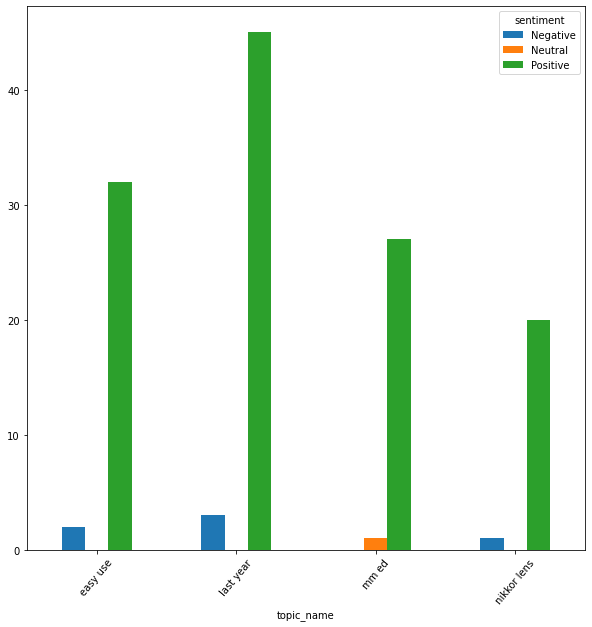

In [23]:
fig = graph_results.plot.bar(rot=50, figsize=(10,10))
fig.figure.savefig('sentiment_analysis.png', bbox_inches='tight')